In [154]:
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from scipy.integrate import dblquad, tplquad


In [2]:
print(const.M_sun)
print(const.G)
print(const.R_jup)

  Name   = Solar mass
  Value  = 1.988409870698051e+30
  Uncertainty  = 4.468805426856864e+25
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2018
  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018
  Name   = Nominal Jupiter equatorial radius
  Value  = 71492000.0
  Uncertainty  = 0.0
  Unit  = m
  Reference = IAU 2015 Resolution B 3


In [160]:


def sigma_cap(v1Mag, v1primeMag, vBMag, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1primeMag**2 - vBMag**2)**2 - v_esc**4)
    denominator = (v1Mag**2 - v_esc**2)**2 * v1primeMag**4
    return numerator / denominator

# def sigma_cap_dEps(v1, v1_prime, vB, v_esc, muB, kappa):
#     """
#     Differential capture cross-section dσ_cap/dε.

#     Parameters
#     ----------
#     v1 : float
#         Incoming velocity.
#     v1_prime : float
#         Incoming velocity in Body B frame.
#     vB : float
#         Orbital velocity of body B.
#     vesc : float
#         Escape velocity of body A or system.
#     muB : float
#         Reduced mass associated with body B (μ_B).
#     kappa : float
#         Energy dissipation parameter.

#     Returns
#     -------
#     float
#         dσ_cap/dε
#     """
#     sigma_cap_val = 16
#     return sigma_cap_val / kappa

def sigma_collision(R, b, bmin, rmin):
    """
    Collision cross-section σ_collision(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    muB : float
        Reduced mass associated with body B (μ_B).
    r_close : float
        Closest approach distance.

    Returns
    -------
    float
        σ_collision(v1)
    """
    sigma_int_1 = -(0.5*(-b + R + bmin) * (b + R - bmin) * (b - R + bmin) * (b + R + bmin))**0.5
    sigma_int_2 = R**2 * np.arccos((b**2 + R**2 - bmin**2) / (2*b*R))
    sigma_int_3 = rmin**2 * np.arccos((b**2 + bmin**2 - R**2) / (2*b*bmin))

    return sigma_int_1 + sigma_int_2 + sigma_int_3
    

def crossec_circle_R_b(v1Mag,  vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB):
    v1_prime_vec_xy = v1primeVec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy)

    g1 = 4*muB*(np.dot(vBVec, v1primeVec))*(v1primeMag**6)*v1primeVec[2]
    g2 = 4*(muB**3)*(np.dot(vBVec, v1primeVec))*(v1primeMag**2)*v1primeVec[2]
    g3 = 4*muB*(v1primeMag**7)*(np.cross(v1primeVec, vBVec))[2]
    g4 = np.sign(v1primeVec[1])*(v1_prime_mag_xy**8)*v1_prime_mag_xy*(v1Mag**2 - vesc**2)
    g5 = 2 * np.sign(v1primeVec[1]) * (muB**2) * (v1primeMag**4) * v1_prime_mag_xy * (v1primeMag**2 + vBMag**2 - vesc**2)

    if g1 == 0 or g4 == 0:
        return 0.0, 0.0

    expr = g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4
    if expr <= 0:
        return 0.0, 0.0

    Rb = np.sqrt(expr)
    b = -0.5*(g3 + g1)/g4

    return Rb, b
    

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def r_min(muA, b, v1_prime):
    """
    Minimum approach distance b_min.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    b : float
        Impact parameter.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        r_min
    """

    e1_prime = np.sqrt(1 + (b**2 * v1_prime**4) / muA**2)
    a1_prime = -b / np.sqrt(e1_prime**2 - 1)
    r_min = (np.sqrt(muA**2 + b**2 * v1_prime**4) - muA) / (v1_prime**2)

    return a1_prime * (1-e1_prime)

def r_AB_vec(rAB, lambda_1):
    """
    Separation vector between bodies A and B r_AB.

    Parameters
    ----------
    rAB : float
        Separation between bodies A and B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    float
        r_AB
    """
    rABVec = rAB * np.array([np.sin(lambda_1), np.cos(lambda_1), 0])
    return rABVec

def b_min(muB, rB, v1_prime):
    """
    Minimum impact parameter b_min.

    Parameters
    ----------
    muB : float
        Reduced mass associated with body B (μ_B).
    rB : float
        Radius of body B.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        b_min
    """
    b_min = np.sqrt(2*muB*rB + (rB*v1_prime)**2) / v1_prime

    return b_min

def v_1_mag(v_inf, muA, muB, rAB, rClose):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / rClose)
    return np.sqrt(term1 + term2)

def v_1_vec(v1Mag, lambda_1, beta_1):
    """
    Incoming velocity v1.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1
    """
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1Mag * np.array([
        np.sin(lambda_1) * np.cos(beta_1),
        np.cos(lambda_1) * np.cos(beta_1),
        -np.sin(beta_1),
    ])
    return v1_vec

def v_1_prime_mag(v1primeVec):
    """
    Magnitude of incoming velocity in Body B frame |v1'|.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        |v1'|
    """
    return np.linalg.norm(v1primeVec)

def v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    v1_prime_vec = v1Vec - vBVec
    return v1_prime_vec

def v_2_vec(v1primeVec,v1primeMag,vBVec, muB, b, phi):
    """
    Outgoing velocity v2.
    Parameters
    ----------
    v1primeVec : float
        Incoming velocity vector in Body B frame.
    v1primeMag : float
        Magnitude of incoming velocity in Body B frame.
    muB : float
        Reduced mass associated with body B (μ_B).
    vB : float
        Orbital velocity of body B.
    b : float
        Impact parameter. 
    Returns
    -------
    float
        v2
    """

    v1prime_vec = v1primeVec.copy()
    v1prime_x = v1prime_vec[0]
    v1prime_y = v1prime_vec[1]
    v1prime_z = v1prime_vec[2]
    v1prime_xy = v1prime_vec.copy()
    v1prime_xy[2] = 0.0
    v1primeMag_xy = np.linalg.norm(v1prime_xy)

    q = np.sqrt(1 + v1prime_z**2/v1primeMag_xy**2)

    term1 = vBVec + (b**2 * v1primeMag**4 - muB**2)/(b**2 * v1primeMag**4 + muB**2) * v1primeVec
    term2 = (2 * np.sign(v1prime_y) * muB * v1primeMag * b)/(b**2 * v1primeMag**4 + muB**2) * np.array([
        q * (v1prime_x * v1prime_z * np.sin(phi) - v1primeMag * v1prime_y * np.cos(phi)),
        q * (v1prime_y * v1prime_z * np.sin(phi) + v1primeMag * v1prime_x * np.cos(phi)),
        -v1primeMag_xy**2 * np.sin(phi)
    ])
    return term1 + term2

def v_2_mag(v2Vec):
    """
    Magnitude of outgoing velocity |v2|.
    Parameters
    ----------
    v2Vec : float
        Outgoing velocity vector.
    Returns
    -------
    float
        |v2|
    """
    return np.linalg.norm(v2Vec)

def v_B_vec(vBMag, lambda_1):
    """
    Orbital velocity vector of body B vB.
    Parameters
    ----------
    vBMag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    Returns
    -------
    float
        vB
    """
    vBVec = vBMag * np.array([np.sin(lambda_1), np.cos(lambda_1), 0])
    return vBVec


def chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigma_cap,  rclose, rB, rmin, Rb, b, bmin):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """
    condition0 = Rb > 0.0
 
    # Condition 1
    v_max = vesc + 2*vBMag
    condition1 = v1Mag < v_max

    # Condition 2
    condition2 = sigma_cap > 0


    # Condition 3 (not needed as sigma_cap already incorporates this

    condition3 = Rb < rclose

    # # Condition 4 r_min should be larger than rB
    # condition4 = rmin > rB

    # Condition 5 b should be larger than b_min
    condition5 = b > bmin

    
    # print(f'Conditions: {condition1}, {condition2}, {condition3}, {condition4}, {condition5}')
    result = 1.0 if (condition0 and condition1 and condition2 and condition3 and condition5) else 0.0

    return result

def chi_inE2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v2Mag, v1Mag, U, E2, rClose):
    """
    Indicator function to check kinematical allowance χ in E2.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ in E2
    """

    # Condition 1
    vesc = v2Mag
    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    condition1 = Rb < rClose

    return 1.0 if condition1 else 0.0

def dsigma_directional_average(sigma_cap, chi):
    """
    Differential directional average cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return (sigma_cap) * chi / (2*np.pi)

def U(muA, muB, rAB, rClose):
    """
    Potential energy U.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    rAB : float
        Separation between bodies A and B.
    rclose : float
        Closest approach distance.

    Returns
    -------
    float
        U parameter
    """
    U  = -(muA / rAB) - (muB / rClose)

    return U

def E2(v2Mag, U):
    """
    Final energy E2.

    Parameters
    ----------
    v2Mag : float
        Magnitude of the outgoing velocity vector.
    U : float
        Potential energy U.

    Returns
    -------
    float
        E2
    """
    return 0.5 * v2Mag**2 + U

def L2(rABVec, v2Vec):
    """
    Angular momentum L2.

    Parameters
    ----------
    rABVec : float
        Separation vector between bodies A and B.
    v2Vec : float
        Outgoing velocity vector.
    muA : float
        Reduced mass associated with body A (μ_A).

    Returns
    -------
    float
        L2
    """
    return np.linalg.norm(np.cross(rABVec, v2Vec))

def a_e(muA, E2, L2):
    """
    Semi-major axis a.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    E2 : float
        Final energy E2.
    L2 : float
        Angular momentum L2.

    Returns
    -------
    float
        a
    """
    a = - muA / (2*E2)
    e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
    return a, e


def sigma_cap_in_E2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v1Mag, U, E2):
    """
    Differential directional average cross-section dσ/dΩ in E2.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    v_inf : float
        Velocity at infinity.
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    vB_mag : float
        Orbital velocity magnitude of body B.
    vesc : float
        Escape velocity of body A or system.
    sigcap : float
        Capture cross-section.
    rclose : float
        Closest approach distance.
    r_jupiter : float
        Radius of Jupiter.

    Returns
    -------
    float
        dσ/dΩ in E2
    """
    term1 = (16*np.pi * muB**2 * (U + E2)/(v1primeMag**4 * (v1Mag**2 - 2*(U-E2))**3)) 
    term2 = (vBMag**2 * (2*v1primeMag**2) + np.dot(vBVec, v1primeVec) + (v1primeMag**2 - 2*(U + E2) * np.dot(vBVec, v1primeVec)))
    sigma_cap_E2 = term1 * term2

    return sigma_cap_E2

In [150]:
G = const.G.value
m_Sun = const.M_sun.value
m_Jup =  const.M_jup.value  # Mass of Jupiter
m_Neptune = 5.15*10**-5 * const.M_sun.value  # Mass of Neptune
M_PBH = 1e-13 * const.M_sun.value
r_SJ = (5.2*u.au).to(u.m).value
r_SN = (30.07*u.au).to(u.m).value
v_Jup = 13.06 * 1e3  # km/s to m/s
v_Neptune = 5.45 * 1e3  # km/s to m/s
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
r_neptune = 24622 * 1e3  # in meters
A_jupiter = np.pi * r_jupiter**2

In [161]:
rAB = r_SJ
rB = r_jupiter
mA = m_Sun
mB = m_Jup
muA = G * mA
muB = G * mB
vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
vBMag = v_Jup
a_SJ = []
e_SJ = []
E2s = []
L2s = []
v2vecs = []
chis = []
i = []
def integrand(cosbeta_1, lambda_1):
    beta_1 = np.arccos(cosbeta_1)
    v1Vec = v_1_vec(v1Mag, lambda_1, beta_1)
    vBVec = v_B_vec(vBMag, lambda_1)
    v1primeVec = v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1)
    v1primeMag = v_1_prime_mag(v1primeVec)
    sigcap = sigma_cap(v1Mag, v1primeMag, vBMag, vesc, muB)

    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    if Rb <= 0.0:
        return 0.0

    bmin = b_min(muB, rB, v1primeMag)
    rmin = r_min(muA, b, v1primeMag)

    allow = chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec,
                vesc, sigcap, rclose, rB, rmin, Rb, b, bmin)
    chis.append(allow)
    dsigma = dsigma_directional_average(sigcap, allow)

     # Calculate orbital parameters if allowed
    
    rABVec = r_AB_vec(rAB, lambda_1)
    v2Vec = v_2_vec(v1primeVec, v1primeMag, vBVec, muB, b, 0.0)
    v2vecs.append(v2Vec)
    v2Mag = v_2_mag(v2Vec)
    U_param = U(muA, muB, rAB, rclose)
    E2_param = E2(v2Mag, U_param)
    if E2_param < 0.0:
        L2_param = L2(rABVec, v2Vec)
        E2s.append(E2_param)
        L2s.append(L2_param)
        a_param, e_param = a_e(muA, E2_param, L2_param)
        a_SJ.append(a_param)
        e_SJ.append(e_param)
    # else:
    #     E2s.append(0.0)
    #     L2s.append(0.0)
    #     a_SJ.append(0.0)
    #     e_SJ.append(0.0)

    return dsigma

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda cosbeta_1: -1,
    lambda cosbeta_1: 1, 

)
print("Integrated directional average cross section:", res, " +/- ", err)
print(f'In terms of Jupiter\'s area: {((res)/A_jupiter)}')

/grad/a.saricaoglu/.conda/envs/compas/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Integrated directional average cross section: 5.291853113096216e+16  +/-  1238053016.5425088
In terms of Jupiter's area: 3.2956646585665434


In [162]:
a_SJ = [(a*u.m).to(u.au).value for a in a_SJ]
print("Average a:", np.mean(a_SJ), 'min:', np.min(a_SJ), 'max:', np.max(a_SJ))
print("Average e:", np.mean(e_SJ), 'min:', np.min(e_SJ), 'max:', np.max(e_SJ))
print("Average E2:", np.mean(E2s), 'min:', np.min(E2s), 'max:', np.max(E2s))
print("Average L2:", np.mean(L2s), 'min:', np.min(L2s), 'max:', np.max(L2s))
print(len(a_SJ), len(e_SJ), len(E2s), len(L2s), i, len(chis), np.sum(chis))

Average a: 20.490340042873243 min: 2.6691811263078686 max: 56.164309921328964
Average e: 0.7853218760086023 min: 0.32898471068391505 max: 0.937946770869543
Average E2: -102226377.11929215 min: -166179780.50368184 max: -7897612.101274371
Average L2: 7207390117873518.0 min: 3023747892607133.0 max: 1.1579821152185932e+16
448 448 448 448 [] 117852 80080.0


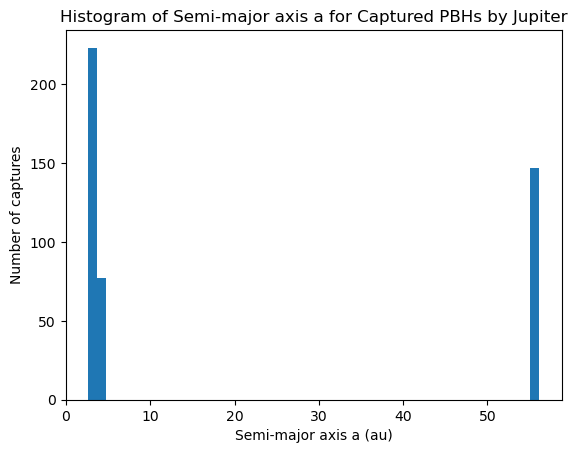

In [163]:
plt.hist(a_SJ[:-1], bins=50)
plt.xlabel('Semi-major axis a (au)')
plt.ylabel('Number of captures')
plt.title('Histogram of Semi-major axis a for Captured PBHs by Jupiter')
plt.show()

In [63]:
rAB = r_SN
rB = r_neptune
mA = m_Sun
mB = m_Neptune
muA = G * mA
muB = G * mB
vesc = v_esc(muA, rAB)
v_inf = 8.436 * 1e3  # km/s to m/s
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
vBMag = v_Neptune
def integrand(cosbeta_1, lambda_1):
    beta_1 = np.arccos(cosbeta_1)
    v1Vec = v_1_vec(v1Mag, lambda_1, beta_1)
    vBVec = v_B_vec(vBMag, lambda_1)
    v1primeVec = v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1)
    v1primeMag = v_1_prime_mag(v1primeVec)
    sigcap = sigma_cap(v1Mag, v1primeMag, vBMag, vesc, muB)

    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    if Rb <= 0.0:
        return 0.0

    bmin = b_min(muB, rB, v1primeMag)
    rmin = r_min(muA, b, v1primeMag)

    allow = chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec,
                vesc, sigcap, rclose, rB, rmin, Rb, b, bmin)

    return dsigma_directional_average(sigcap, allow)

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda cosbeta_1: -1,
    lambda cosbeta_1: 1, 
    epsabs=1e-10,
    epsrel=1e-10,

)
print("Integrated directional average cross section:", res, " +/- ", err)
print(f'In terms of Jupiter\'s area: {((res)/A_jupiter)}')

Integrated directional average cross section: 1.8075426322895132e+16  +/-  104836.5
In terms of Jupiter's area: 1.1257028955218809


In [ ]:

G = const.G.value
mA = const.M_sun.value
muA = G * mA
mB =  const.M_jup.value  # Mass of Jupiter
muB = G * mB
M_PBH = 1e-13 * const.M_sun.value
rAB = (5.2*u.au).to(u.m).value
vB_mag = 13.06 * 1e3  # km/s to m/s
kappa = 25
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
A_jupiter = np.pi * r_jupiter**2

def sigma_cap(v1Mag, v1primeMag, vBMag, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1primeMag**2 - vBMag**2)**2 - v_esc**4)
    denominator = (v1Mag**2 - v_esc**2)**2 * v1primeMag**4
    return numerator / denominator

# def sigma_cap_dEps(v1, v1_prime, vB, v_esc, muB, kappa):
#     """
#     Differential capture cross-section dσ_cap/dε.

#     Parameters
#     ----------
#     v1 : float
#         Incoming velocity.
#     v1_prime : float
#         Incoming velocity in Body B frame.
#     vB : float
#         Orbital velocity of body B.
#     vesc : float
#         Escape velocity of body A or system.
#     muB : float
#         Reduced mass associated with body B (μ_B).
#     kappa : float
#         Energy dissipation parameter.

#     Returns
#     -------
#     float
#         dσ_cap/dε
#     """
#     sigma_cap_val = 16
#     return sigma_cap_val / kappa

def sigma_collision(R, b, bmin, rmin):
    """
    Collision cross-section σ_collision(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    muB : float
        Reduced mass associated with body B (μ_B).
    r_close : float
        Closest approach distance.

    Returns
    -------
    float
        σ_collision(v1)
    """
    sigma_int_1 = -(0.5*(-b + R + bmin) * (b + R - bmin) * (b - R + bmin) * (b + R + bmin))**0.5
    sigma_int_2 = R**2 * np.arccos((b**2 + R**2 - bmin**2) / (2*b*R))
    sigma_int_3 = rmin**2 * np.arccos((b**2 + bmin**2 - R**2) / (2*b*bmin))

    return sigma_int_1 + sigma_int_2 + sigma_int_3
    

def crossec_circle_R_b(v1Mag,  vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB):
    """
    Cross-section of a circle with radius R center b (impact parameter).

    Parameters
    ----------
    R : float
        Radius of the circle.
    b : float
        Center of the circle.
        
    Returns
    -------
    float
        cross-section radius R_b
    float
        impact parameter b
    """
    v1_prime_vec_xy = v1primeVec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy)
    g1 = 4*muB*(np.dot(vBVec, v1primeVec))*(v1primeMag**6)*v1primeVec[2]
    g2 = 4*(muB**3)*(np.dot(vBVec, v1primeVec))*(v1primeMag**2)*v1primeVec[2]
    g3 = 4*muB*(v1primeMag**7)*(np.cross(v1primeVec, vBVec))[2]
    g4 = np.sign(v1primeVec[1])*(v1_prime_mag_xy**8)*v1_prime_mag_xy*(v1Mag**2 - vesc**2)
    g5 = 2 * np.sign(v1primeVec[1]) * (muB**2) * (v1primeMag**4) * v1_prime_mag_xy * (v1primeMag**2 + vBMag**2 - vesc**2)
    # compute g1..g5 first
    if g1 == 0 or g4 == 0:
        return 0.0

    expr = g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4
    if expr <= 0:
        return 0.0, 0.0
    
    R = np.sqrt(g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4)

    b = -1/(2*g4) * (g3 + g1)

    return R, b
    

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def r_min(muA, b, v1_prime):
    """
    Minimum approach distance b_min.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    b : float
        Impact parameter.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        r_min
    """

    e1_prime = np.sqrt(1 + (b**2 * v1_prime**4) / muA**2)
    a1_prime = -b / np.sqrt(e1_prime**2 - 1)
    r_min = (np.sqrt(muA**2 + b**2 * v1_prime**4) - muA) / (v1_prime**2)

    return a1_prime * (1-e1_prime)

def b_min(muB, rB, v1_prime):
    """
    Minimum impact parameter b_min.

    Parameters
    ----------
    muB : float
        Reduced mass associated with body B (μ_B).
    rB : float
        Radius of body B.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        b_min
    """
    b_min = np.sqrt(2*muB*rB + (rB*v1_prime)**2) / v1_prime

    return b_min

def v_1_mag(v_inf, muA, muB, rAB, rClose):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / rClose)
    return np.sqrt(term1 + term2)

def v_1_vec(v1Mag, lambda_1, beta_1):
    """
    Incoming velocity v1.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1
    """
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1Mag * np.array([
        np.sin(lambda_1) * np.cos(beta_1),
        np.cos(lambda_1) * np.cos(beta_1),
        -np.sin(beta_1),
    ])
    return v1_vec

def v_1_prime_mag(v1primeVec):
    """
    Magnitude of incoming velocity in Body B frame |v1'|.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        |v1'|
    """
    return np.linalg.norm(v1primeVec)

def v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    v1_prime_vec = v1Vec - vBVec
    return v1_prime_vec

def v_2_vec(v1primeVec,v1primeMag,vBVec, muB, b, phi):
    """
    Outgoing velocity v2.
    Parameters
    ----------
    v1primeVec : float
        Incoming velocity vector in Body B frame.
    v1primeMag : float
        Magnitude of incoming velocity in Body B frame.
    muB : float
        Reduced mass associated with body B (μ_B).
    vB : float
        Orbital velocity of body B.
    b : float
        Impact parameter. 
    Returns
    -------
    float
        v2
    """

    v1prime_vec = v1primeVec.copy()
    v1prime_x = v1prime_vec[0]
    v1prime_y = v1prime_vec[1]
    v1prime_z = v1prime_vec[2]
    v1prime_xy = v1prime_vec.copy()
    v1prime_xy[2] = 0.0
    v1primeMag_xy = np.linalg.norm(v1prime_xy)

    q = np.sqrt(1 + v1prime_z**2/v1prime_xy**2)

    term1 = vBVec + (b**2 * v1primeMag**4 - muB**2)/(b**2 * v1primeMag**4 + muB**2) * v1primeVec
    term2 = (2 * np.sign(v1prime_y) * muB * v1primeMag * b)/(b**2 * v1primeMag**4 + muB**2) * np.array([
        q * (v1prime_x * v1prime_z * np.sin(phi) - v1primeMag * v1prime_y * np.cos(phi)),
        q * (v1prime_y * v1prime_z * np.sin(phi) + v1primeMag * v1prime_x * np.cos(phi)),
        -v1primeMag_xy**2 * np.sin(phi)
    ])
    return term1 + term2

def v_2_mag(v2Vec):
    """
    Magnitude of outgoing velocity |v2|.
    Parameters
    ----------
    v2Vec : float
        Outgoing velocity vector.
    Returns
    -------
    float
        |v2|
    """
    return np.linalg.norm(v2Vec)

def v_B_vec(vBMag, lambda_1):
    """
    Orbital velocity vector of body B vB.
    Parameters
    ----------
    vBMag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    Returns
    -------
    float
        vB
    """
    vBVec = vBMag * np.array([np.sin(lambda_1), np.cos(lambda_1), 0])
    return vBVec


def chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigma_cap,  rclose, rB, rmin, Rb, b, bmin):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """
    condition0 = Rb > 0.0
 
    # Condition 1
    v_max = vesc + 2*vBMag
    condition1 = v1Mag < v_max

    # Condition 2
    condition2 = sigma_cap > 0


    # Condition 3 (not needed as sigma_cap already incorporates this

    condition3 = Rb < rclose

    # Condition 4 r_min should be larger than rB
    condition4 = rmin > rB

    # Condition 5 b should be larger than b_min
    condition5 = b > bmin

    
    # print(f'Conditions: {condition1}, {condition2}, {condition3}, {condition4}, {condition5}')
    result = 1.0 if (condition0 and condition1 and condition2 and condition3 and condition4 and condition5) else 0.0

    return result

def chi_inE2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v2Mag, v1Mag, U, E2, rClose):
    """
    Indicator function to check kinematical allowance χ in E2.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ in E2
    """

    # Condition 1
    vesc = v2Mag
    R, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    condition1 = R < rClose

    return 1.0 if condition1 else 0.0

def dsigma_directional_average(sigma_cap, chi):
    """
    Differential directional average cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return (sigma_cap) * chi / (2*np.pi)

def U(muA, muB, rAB, rClose):
    """
    Potential energy U.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    rAB : float
        Separation between bodies A and B.
    rclose : float
        Closest approach distance.

    Returns
    -------
    float
        U parameter
    """
    U  = -(muA / rAB) - (muB / rClose)

    return U

def E2(v2Mag, U):
    """
    Final energy E2.

    Parameters
    ----------
    v2Mag : float
        Magnitude of the outgoing velocity vector.
    U : float
        Potential energy U.

    Returns
    -------
    float
        E2
    """
    return 0.5 * v2Mag**2 + U

def sigma_cap_in_E2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v1Mag, U, E2):
    """
    Differential directional average cross-section dσ/dΩ in E2.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    v_inf : float
        Velocity at infinity.
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    vB_mag : float
        Orbital velocity magnitude of body B.
    vesc : float
        Escape velocity of body A or system.
    sigcap : float
        Capture cross-section.
    rclose : float
        Closest approach distance.
    r_jupiter : float
        Radius of Jupiter.

    Returns
    -------
    float
        dσ/dΩ in E2
    """
    term1 = (16*np.pi * muB**2 * (U + E2)/(v1primeMag**4 * (v1Mag**2 - 2*(U-E2))**3)) 
    term2 = (vBMag**2 * (2*v1primeMag**2) + np.dot(vBVec, v1primeVec) + (v1primeMag**2 - 2*(U + E2) * np.dot(vBVec, v1primeVec)))
    sigma_cap_E2 = term1 * term2

    return sigma_cap_E2

vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
vBMag = vB_mag
def integrand(cosbeta_1, lambda_1):  # func(y, x): y = cosbeta_1, x = lambda_1
    beta_1 = np.arccos(cosbeta_1)
    v1Vec = v_1_vec(v1Mag, lambda_1, beta_1)
    vBVec = v_B_vec(vBMag, lambda_1)
    v1primeVec = v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1)
    v1primeMag = v_1_prime_mag(v1primeVec)
    sigcap = sigma_cap(v1Mag, v1primeMag, vBMag, vesc, muB)
    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    bmin = b_min(muB, r_jupiter, v1primeMag)
    rmin = r_min(muA, b, v1primeMag)
    # if rmin > r_jupiter:
    #     print(f'b-bmin: {b - bmin}, rmin - rjupiter: {rmin - r_jupiter}')
    # sigcol = sigma_collision(R, b, bmin, rmin)
    allow = chi(muB,v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigcap, rclose,r_jupiter, rmin, Rb, b, bmin)
    # print(allow)
    return dsigma_directional_average(sigcap, allow)

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda cosbeta_1: -1,
    lambda cosbeta_1: 1, 

)
print("Integrated directional average cross section:", res, " +/- ", err)
print(f'In terms of Jupiter\'s area: {((res)/A_jupiter)}')

NameError: name 'rmin' is not defined

without chi:
14.97410460456744 for 0, 2pi for lambda & 0, pi for beta
7.4870481200022825 for 0, pi for lambda & 0, pi for beta
with chi:
14.999128490217245 for 0, 2pi for lambda & 0, pi for beta
7.499568974815175 for 0, pi for lambda & 0, pi for beta
with chi & b check:
11.254511033661727 for 0, 2pi for lambda & 0, pi for beta
5.62726654507256 for 0, pi for lambda & 0, pi for beta
with chi & bmin check:
9.597438931190169 for 0, 2pi for lambda & 0, pi for beta
4.798699093001559 for 0, pi for lambda & 0, pi for beta

In [ ]:

G = const.G.value
mA = const.M_sun.value
muA = G * mA
mB =  const.M_jup.value  # Mass of Jupiter
muB = G * mB
M_PBH = 1e-13 * const.M_sun.value
rAB = (5.2*u.au).to(u.m).value
vB_mag = 13.06 * 1e3  # km/s to m/s
kappa = 25
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
A_jupiter = np.pi * r_jupiter**2

def sigma_cap(v1, v1_prime, vB, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1_prime**2 - vB**2)**2 - v_esc**4)
    denominator = (v1**2 - v_esc**2)**2 * v1_prime**4
    return numerator / denominator

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def v_1(v_inf, muA, muB, rAB, r_close):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / r_close)
    return np.sqrt(term1 + term2)

def v_1_prime(v1_mag, vB_mag, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    # B moves along +y
    vB_vec = np.array([0.0, vB_mag, 0.0])
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1_mag * np.array([
        np.cos(lambda_1) * np.cos(beta_1),
        np.sin(lambda_1) * np.cos(beta_1),
        np.sin(beta_1),
    ])
    v1_prime_vec = v1_vec - vB_vec
    return np.linalg.norm(v1_prime_vec)

def chi(muB,v1_mag, vB_mag, vesc, sigma_cap, lambda_1, beta_1, rclose):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """

    # Condition 1
    v_max = vesc + 2*vB_mag
    condition1 = v1_mag < v_max

    # Condition 2
    condition2 = sigma_cap > 0


    # Condition 3 (not needed as sigma_cap already incorporates this)

    # B moves along +y
    vB_vec = np.array([0.0, vB_mag, 0.0])
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1_mag * np.array([
        np.cos(lambda_1) * np.cos(beta_1),
        np.sin(lambda_1) * np.cos(beta_1),
        np.sin(beta_1),
    ])

    v1_prime_vec = v1_vec - vB_vec
    v1_prime_mag = np.linalg.norm(v1_prime_vec)
    v1_prime_vec_xy = v1_prime_vec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy)
    g1 = 4*muB*(np.dot(vB_vec, v1_prime_vec))*(v1_prime_mag**6)*v1_prime_vec[2]
    g2 = 4*(muB**3)*(np.dot(vB_vec, v1_prime_vec))*(v1_prime_mag**2)*v1_prime_vec[2]
    g3 = 4*muB*(v1_prime_mag**7)*(np.cross(v1_prime_vec, vB_vec))[2]
    g4 = np.sign(v1_prime_vec[1])*(v1_prime_mag**8)*v1_prime_mag_xy*(v1_mag**2 - vesc**2)
    g5 = 2 * np.sign(v1_prime_vec[1]) * (muB**2) * (v1_prime_mag**4) * v1_prime_mag_xy * (v1_mag**2 + vB_mag**2 - vesc**2)
    R = np.sqrt(g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4)

    condition3 = R < rclose

    result = 1.0 if (condition1 and condition2 and condition3) else 0.0

    return result

def dsigma(lambda_1, cosbeta_1, sigma_cap, chi):
    """
    Differential cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return sigma_cap * chi / (2*np.pi)
vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1_mag = v_1(v_inf, muA, muB, rAB, rclose)

def integrand(cosbeta_1, lambda_1):  # func(y, x): y = cosbeta_1, x = lambda_1
    beta_1 = np.arccos(cosbeta_1)
    v1p = v_1_prime(v1_mag, vB_mag, lambda_1, beta_1)
    sigcap = sigma_cap(v1_mag, v1p, vB_mag, vesc, muB)
    allow = chi(muB,v1_mag, vB_mag, vesc, sigcap, lambda_1, beta_1, rclose)
    return dsigma(lambda_1, cosbeta_1, sigcap, allow)

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda lam: -1,
    lambda lam: 1
)
print("Integrated cross section:", res, " +/- ", err)